# Figure 7

In [1]:
import sys
sys.path.append('..')

from db import *
from analysis import *

In [2]:
data = (
    session.query(
        Languages.name_short.label("lang"),
        Languages.common_crawl_pages,
        func.count(ImageCreationRequest.id).label("total_requests"),
        func.count(case((ImageCreationRequest.success == True, 1))).label("success_count"),
        func.count(case((ImageCreationRequest.success == False, 1))).label("failure_count"),
        func.coalesce(
            func.count(case((ImageCreationRequest.success == True, 1))) * 1.0 /
            func.count(ImageCreationRequest.id), 0
        ).label("acceptance_rate"),
    )
    .join(TranslatedPrompts, ImageCreationRequest.translated_prompt_id == TranslatedPrompts.id)
    .join(Languages, TranslatedPrompts.language_id == Languages.id)
    .join(Prompts, TranslatedPrompts.prompt_id == Prompts.id)
    .join(PromptPrefixStyles, ImageCreationRequest.prompt_prefix_id == PromptPrefixStyles.id)
    .filter(
        ImageCreationRequest.model == 'dalle-3',
        PromptPrefixStyles.name == 'exact',
        Prompts.dataset == 'baseline'
    )
    .group_by(Languages.id, Languages.name_short, Languages.common_crawl_pages)
    .order_by(Languages.common_crawl_pages.desc())
)

df = query_to_df(data)
len(df)

27

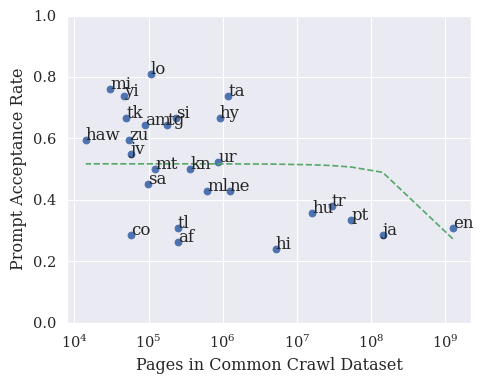

In [3]:
x_metric = 'common_crawl_pages'
y_metric = 'acceptance_rate'

fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(df[x_metric], df[y_metric])

ax.set_ylim([0, 1])

z = np.polyfit(df[x_metric], df[y_metric], 1)
p = np.poly1d(z)
ax.plot(df[x_metric], p(df[x_metric]), "--", color=palette[2])

ax.set_xscale('log')

# Adding language labels
for i, txt in enumerate(df['lang']):
    ax.annotate(txt, (df[x_metric].iloc[i], df[y_metric].iloc[i]))

# Setting labels and title
ax.set_xlabel('Pages in Common Crawl Dataset')
ax.set_ylabel('Prompt Acceptance Rate')
plt.tight_layout()
plt.show()